# Function Definition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, math
import warnings
warnings.filterwarnings("ignore")

def get_df_single_round(reports_path):
    '''
    Return both performance and resource monitoring dataframes. 
    '''
    df_ls1, df_ls2 = [], []
    file_list = sorted(os.listdir(reports_path))
    file_list = [file for file in file_list if 'report' in file and '.html' in file]
    for file in file_list:
        df_ls = pd.read_html(os.path.join(reports_path, file), flavor='bs4')
        # calculate resources
        df_resource = df_ls[2]
        # df_resource = df_resource.drop(labels = df_resource.columns[4:8], axis=1)
        if 'Memory(max) [MB]' in df_resource.columns:
            cols = []
            for col in df_resource.columns:
                if 'MB' in col:
                    col = col.replace('MB', 'GB')
                cols.append(col)
            df_resource.columns = cols
            df_resource[cols[3:5]] = df_resource[cols[3:5]]/1000
        # calculate performance
        df_perf=df_ls[0]
        rates = int(file.split('-')[1])
        df_perf['Rate'] = rates
        df_resource['Rate'] = rates
        
        df_ls1.append(df_perf)
        df_ls2.append(df_resource)
    df1 = pd.concat(df_ls1)
    df2 = pd.concat(df_ls2)
    return df1, df2

def get_df_multi_rounds(reports_path):
    '''
    Input: the path for all 5+ rounds of reports
    Output: dataframes with all collected data for both performance and resources
    '''
    reports_folders = os.listdir(reports_path)
    network_size = int(reports_path.split('/')[-1].split('_')[0])
    paths = []
    df_ls_perf, df_ls_resource = [], []
    for folder in reports_folders:
        curr_reports_path = reports_path+'/'+folder
        reports = [file for file in os.listdir(curr_reports_path) if 'report' in file and '.html' in file]
        if len(reports) < 50:
            print('{} has {} reports.'.format(folder, len(reports)))
        df_perf, df_resource = get_df_single_round(curr_reports_path)
        nodenum = len(df_resource.index.unique())
        if nodenum == network_size:
            df_ls_perf.append(df_perf)
            df_ls_resource.append(df_resource)
        else:
            print('{} has {} out of {} nodes.'.format(folder, nodenum, network_size))
    print(len(df_ls_perf), 'rounds of reports are collected!')
    df1 = pd.concat(df_ls_perf)
    df2 = pd.concat(df_ls_resource)
    return df1, df2

def plot_perf(df_resource: pd.DataFrame, withArrivalRate=False):
    roundLabels = ['open', 'query', 'transfer']
    metricLabels = ['Throughput (TPS)', 'Avg Latency (s)', 'Send Rate (TPS)']
    
    data = []
    for metric in metricLabels:
        values = []
        for index in roundLabels:
            res = df_resource[df_resource.index == index][metric].values
            values.append(res)
        data.append(values)
    
    rates = df_resource[df_resource.index == roundLabels[0]]['Rate'].values
    rows, cols = 1, 2
    fig, axes = plt.subplots(figsize=(16,5), ncols=cols, nrows=rows)
    axes[0].plot(rates, data[0][0], label='open', marker='*', color='tab:red')
    axes[0].plot(rates, data[0][1], label='query', marker='d', color='tab:blue')
    axes[0].plot(rates, data[0][2], label='transfer', marker='<', color='tab:green')
    if withArrivalRate:
        axes[0].plot(rates, data[2][0], '--', label='open arrival rate', marker='*', color='tab:red')
        axes[0].plot(rates, data[2][1], '--', label='query arrival rate', marker='d', color='tab:blue')
        axes[0].plot(rates, data[2][2], '--', label='transfer arrival rate', marker='<', color='tab:green')
    axes[0].set(title='Besu Throughput under Varying Send Rates', xticks=rates,
        xlabel='Transaction Send Rate (req/s)', ylabel='Throughput (TPS)')
    axes[0].grid()
    axes[0].legend()

    axes[1].plot(rates, data[1][0], label='open', marker='*')
    axes[1].plot(rates, data[1][1], label='query', marker='d')
    axes[1].plot(rates, data[1][2], label='transfer', marker='<')
    axes[1].set(title='Besu Latency under Varying Send Rates', xticks=rates,
        xlabel='Transaction Send Rate (req/s)', ylabel='Latency (S)')
    axes[1].grid()
    axes[1].legend()

def plot_resource(df_resource, jvm_max_heap):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
    node_names = df_resource.index.unique()
    len_nodes = len(node_names)
    metrics = df_resource.columns[:4]
    for i in range(1, len_nodes+1):
        node = 'besu-'+str(i)
        df_node = df_resource[df_resource.index == node]
        X = df_node.Rate.values
        # Y1 = df_node[metrics[2]].values
        # axes[0].plot(X, Y1, '--', marker='*', label=node+' '+metrics[2])
        Y2 = df_node[metrics[3]].values
        axes[0].plot(X, Y2, marker='d', label=node)
        
        # Y3 = df_node[metrics[0]].values
        # axes[1].plot(X, Y3, '--', marker='*', label=node+' '+metrics[0])
        Y4 = df_node[metrics[1]].values
        axes[1].plot(X, Y4, marker='d', label=node)
        
    axes[0].set(xticks=X, xlabel='Transaction Send Rate (req/s)', ylabel='Memory Usage (GB)',
                title='Besu Node' + ' '+metrics[3])
    if jvm_max_heap:    
        axes[0].axhline(y=jvm_max_heap, color='r', linestyle='--', label='JVM XMX')
    axes[0].grid()
    ncol = math.ceil(len_nodes/10)
    axes[0].legend(loc='upper right', ncol=ncol,handleheight=2.4, labelspacing=0.05)
    axes[1].set(xticks=X, xlabel='Transaction Send Rate (req/s)', ylabel='CPU Usage (%)',
            title='Besu Node'+' '+metrics[1])
    axes[1].grid()
    axes[1].legend(loc='upper right', ncol=ncol,handleheight=2.4, labelspacing=0.05)
    plt.show()

def plot_all(df_perf, df_resource, jvm_max_heap, withArrivalRate=False):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
    ## plot resources
    node_names = df_resource.index.unique()
    len_nodes = len(node_names)
    metrics = df_resource.columns[:4]
    for i in range(1, len_nodes+1):
        node = 'besu-'+str(i)
        df_node = df_resource[df_resource.index == node]
        X = df_node.Rate.values
        Y2 = df_node[metrics[3]].values
        axes[0][0].plot(X, Y2, marker='d', label=node)
        Y4 = df_node[metrics[1]].values
        axes[0][1].plot(X, Y4, marker='d', label=node)
    axes[0][0].set(xticks=X, xlabel='Transaction Send Rate (req/s)', ylabel='Memory Usage (GB)',
                title='Besu Node'+' '+metrics[3])
    if jvm_max_heap:
        axes[0][0].axhline(y=jvm_max_heap, color='r', linestyle='--', label='JVM XMX')
    axes[0][0].grid()
    ncol = math.ceil(len_nodes/10)
    axes[0][0].legend(loc='upper left', ncol=ncol,handleheight=2.4, labelspacing=0.05)
    axes[0][1].set(xticks=X, xlabel='Transaction Send Rate (req/s)', ylabel='CPU Usage (%)',
            title='Besu Node'+' '+metrics[1])
    axes[0][1].grid()
    axes[0][1].legend(loc='upper right', ncol=ncol,handleheight=2.4, labelspacing=0.05)
    
    ## plot perforamnce
    roundLabels = ['open', 'query', 'transfer']
    metricLabels = ['Throughput (TPS)', 'Avg Latency (s)', 'Send Rate (TPS)']
    
    data = []
    for metric in metricLabels:
        values = []
        for index in roundLabels:
            res = df_perf[df_perf.index == index][metric].values
            values.append(res)
        data.append(values)
    
    rates = df_perf[df_perf.index == roundLabels[0]]['Rate'].values
    axes[1][0].plot(rates, data[0][0], label='open', marker='*', color='tab:red')
    axes[1][0].plot(rates, data[0][1], label='query', marker='d', color='tab:blue')
    axes[1][0].plot(rates, data[0][2], label='transfer', marker='<', color='tab:green')
    if withArrivalRate:
        axes[1][0].plot(rates, data[2][0], '--', label='open arrival rate', marker='*', color='tab:red')
        axes[1][0].plot(rates, data[2][1], '--', label='query arrival rate', marker='d', color='tab:blue')
        axes[1][0].plot(rates, data[2][2], '--', label='transfer arrival rate', marker='<', color='tab:green')
    axes[1][0].set(title='Besu Throughput under Varying Send Rates', xticks=rates,
        xlabel='Transaction Send Rate (req/s)', ylabel='Throughput (TPS)')
    axes[1][0].grid()
    axes[1][0].legend()

    axes[1][1].plot(rates, data[1][0], label='open', marker='*')
    axes[1][1].plot(rates, data[1][1], label='query', marker='d')
    axes[1][1].plot(rates, data[1][2], label='transfer', marker='<')
    axes[1][1].set(title='Besu Latency under Varying Send Rates', xticks=rates,
        xlabel='Transaction Send Rate (req/s)', ylabel='Latency (S)')
    axes[1][1].grid()
    axes[1][1].legend()
    plt.tight_layout()
    plt.show()

def cal_mean(df):
    ''' 
    Calculate mean value grouping by rate for all three rounds or different nodes
    '''
    rates = sorted(df.Rate.unique())
    df_ls = []
    for rate in rates:
        df_mean = df[df.Rate == rate].groupby('Name').mean().round(2)
        df_ls.append(df_mean)
    return pd.concat(df_ls)


def plot(reports_path, jvm_max_heap=None, all_in_one=True):
    '''
    jvm_max_heap = 7.28 * 0.8 = 5.83 or 7.28 * 0.25 = 1.82
    '''
    f = reports_path.split('/')[-1]
    if '2022' in f:
        df_perf, df_res = get_df_single_round(reports_path)
    else:
        df_perf, df_res = get_df_multi_rounds(reports_path)

    df_perf_mean, df_res_mean = cal_mean(df_perf), cal_mean(df_res)
    df_res_mean.index = [index.split('/')[1] for index in df_res_mean.index]

    if all_in_one:
        plot_all(df_perf_mean, df_res_mean, jvm_max_heap, True)
    else:
        plot_perf(df_res_mean)
        plot_resource(df_res_mean, jvm_max_heap)
        
def plot_perf_merge(reports_path):
    df_perf, df_res = get_df_multi_rounds(reports_path)
    df = cal_mean(df_perf)
    # df_res_mean = cal_mean(df_res)
    # df_res_mean.index = [index.split('/')[1] for index in df_res_mean.index]
    roundLabels = ['open', 'transfer', 'query']
    metricLabels = ['Throughput (TPS)', 'Avg Latency (s)', 'Send Rate (TPS)']
    
    data = []
    for metric in metricLabels:
        values = []
        for index in roundLabels:
            res = df[df.index == index][metric].values
            values.append(res)
        data.append(values)
    
    rates = df[df.index == roundLabels[0]]['Rate'].values.astype(int)
    width = 0.2
    X_axis = np.arange(1, len(rates)+1)
    
    fig, ax1 = plt.subplots(figsize=(8,5))
    ax1.bar(X_axis - width, data[0][0], width=width, label='open', color='tab:red')
    ax1.bar(X_axis, data[0][1], width=width, label='transfer', color='tab:blue')
    ax1.bar(X_axis + width, data[0][2], width=width, label='query', color='tab:green')
    ax1.set(ylabel='Average Throughput (TPS)')
    ax1.set_xlabel('Transaction Send Rate (req/s)')
    ax1.grid()

    ax2 = ax1.twinx()

    ax2.plot(X_axis, data[1][0], label='open', marker='<', color='tab:red')
    ax2.plot(X_axis, data[1][1], label='transfer', marker='d', color='tab:blue')
    ax2.plot(X_axis, data[1][2], label='query', marker='*', color='tab:green', linewidth=2)
    ax2.set(title='Besu Performance under Varying Send Rates', ylabel='Average Latency (S)')
    ax2.set_ylim(0, 2.1)
    
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    # Create custom legend by unpacking tuples containing handles and using 
    # only one set of unpacked labels along with set of unpacked empty strings
    # (using None instead of empty strings gives the same result)
    ax1.legend((*handles1, *handles2), (*len(labels1)*[''], *labels2),
                 loc='upper left', ncol=2, handlelength=3, edgecolor='black',
                 borderpad=0.7, handletextpad=1.5, columnspacing=0)
    plt.xticks(X_axis, rates)

def parse_values(values_str):
    res = []
    for line in values_str:
      line = [float(a) for a in line.replace('\n','').strip('][').split(' ') if (a != '')]
      res.append(line)
    return res

In [2]:
# Set report base bath
import sys

basepath = "/home/ubuntu/mnt/experiments_bpet/reports/"
plotdatapath = "/home/ubuntu/mnt/bpet/src/plotdata/"

sys.path.append(basepath)
sys.path.append(plotdatapath)

# Heavy Load on Baseline

In [2]:
dfperfb, dfresb = get_df_multi_rounds(reports_path='/home/ubuntu/mnt/experiments_bpet/reports/8_LB_2C7.5G_QBFT_1S')
dfperf, dfres = get_df_multi_rounds(reports_path='/home/ubuntu/mnt/experiments_bpet/reports/8_LB_2C7.5G_QBFT_1S_HEAVY_LOAD')
df_data = pd.concat([dfperfb, dfperf])
df = df_data.groupby(by=['Rate', 'Name']).mean()

5 rounds of reports are collected!
1 rounds of reports are collected!


In [4]:
heavy_plot_data_path = '{}heavy_load.csv'.format(plotdatapath)
df = pd.read_csv(heavy_plot_data_path)
df

,Rate,Name,Succ,Fail,Send Rate (TPS),Max Latency (s),Min Latency (s),Avg Latency (s),Throughput (TPS)
0,100,open,1000.0,0.0,100.392,1.2556,0.1420,0.6776,93.704
1,100,query,1000.0,0.0,100.356,0.0360,0.0000,0.0000,100.316
2,100,transfer,1000.0,0.0,100.384,1.2436,0.1264,0.6908,94.880
3,200,open,1000.0,0.0,200.480,1.3248,0.1928,0.7516,172.792
4,200,query,1000.0,0.0,200.312,0.0188,0.0000,0.0000,200.220
...,...,...,...,...,...,...,...,...,...
295,9900,query,1000.0,0.0,2873.232,0.0204,0.0000,0.0000,2855.196
296,9900,transfer,1000.0,0.0,1461.568,1.9528,1.1120,1.5288,414.152
297,10000,open,1000.0,0.0,1422.948,1.9120,1.2480,1.5632,425.444
298,10000,query,1000.0,0.0,2928.236,0.0204,0.0000,0.0000,2913.876


In [5]:
upbound = 10000
rates = np.arange(100, upbound+1, 100)

df_tps_open = df[(df['Name']=='open') & (df['Rate'] <= upbound)]
df_tps_tran = df[(df['Name'] == 'transfer') & (df['Rate'] <= upbound)]
df_tps_query = df[(df['Name'] =='query') & (df['Rate'] <= upbound)]

df_lat_open = df[(df['Name']=='open') & (df['Rate'] <= upbound)]
df_lat_tran = df[(df['Name'] == 'transfer') & (df['Rate'] <= upbound)]
df_lat_query = df[(df['Name'] =='query') & (df['Rate'] <= upbound)]

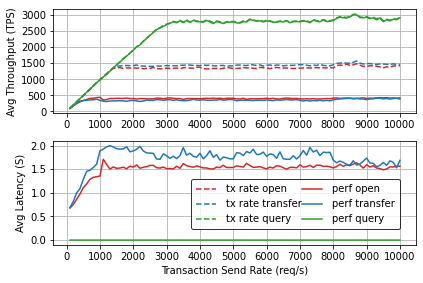

In [7]:
fig, axes = plt.subplots(figsize=(6,4), ncols=1, nrows=2, sharex=False)
xticks = np.arange(0, upbound+1, 1000)

axes[0].plot(rates, df_tps_open['Send Rate (TPS)'], linestyle='--', color='tab:red', label='tx rate open')
axes[0].plot(rates, df_tps_open['Throughput (TPS)'], color='tab:red')
axes[0].plot(rates, df_tps_tran['Send Rate (TPS)'], linestyle='--', color='tab:blue',label='tx rate transfer')
axes[0].plot(rates, df_tps_tran['Throughput (TPS)'], color='tab:blue', )
axes[0].plot(rates, df_tps_query['Send Rate (TPS)'], linestyle='--', color='tab:green',label='tx rate query')
axes[0].plot(rates, df_tps_query['Throughput (TPS)'], color='tab:green', )
axes[0].set_yticks(np.arange(0, 3100, 500))
axes[0].set_xticks(xticks)
axes[0].set_ylabel('Avg Throughput (TPS)')
# axes[0].legend()
axes[0].grid()

axes[1].plot(rates, df_lat_open['Avg Latency (s)'], color='tab:red', label='perf open')
axes[1].plot(rates, df_lat_tran['Avg Latency (s)'], color='tab:blue', label='perf transfer')
axes[1].plot(rates, df_lat_query['Avg Latency (s)'], color='tab:green', label='perf query')
axes[1].set_xlabel('Transaction Send Rate (req/s)')
axes[1].set_xticks(xticks)
axes[1].set_yticks(np.arange(0,2.1,0.5))
axes[1].set_yticks
# axes[1].legend()
axes[1].grid()
axes[1].set_ylabel('Avg Latency (S)')

handles1, labels1 = axes[0].get_legend_handles_labels()
handles2, labels2 = axes[1].get_legend_handles_labels()
axes[1].legend((*handles1, *handles2), (*labels1, *labels2),
             loc=(0.38,0.15), ncol=2, handlelength=2, edgecolor='black',
             borderpad=0.5, handletextpad=1, columnspacing=0)

plt.tight_layout()
plt.show()
fig.set_size_inches(6,4)
fig.savefig('./figs/heavy_load.png', dpi=300)
fig.savefig('./figs/heavy_load.pdf')

# Scale-out

## QBFT

In [51]:
def calculate_scaleout(consensus, netsizes):
    sendrate = 1000
    open_lat, open_tps = [], []
    transfer_lat, transfer_tps = [], []
    query_lat, query_tps = [], []
    for n in netsizes:
        folder = '{}_LB_2C7.5G_{}_1S'.format(n, consensus)
        if consensus in ['IBFT2', 'CLIQUE']:
            folder = '{}_LB_2C7.5G_{}_1S_1000TPS'.format(n, consensus)
        reports_path = basepath + folder
        print('Processing reports of {}'.format(folder))
        df, _ = get_df_multi_rounds(reports_path)
        df = df[df.Rate == sendrate]

        open_lat.append(df[df.Name=='open']['Avg Latency (s)'].values)
        open_tps.append(df[df.Name=='open']['Throughput (TPS)'].values)
        transfer_lat.append(df[df.Name=='transfer']['Avg Latency (s)'].values)
        transfer_tps.append(df[df.Name=='transfer']['Throughput (TPS)'].values)
        query_lat.append(df[df.Name=='query']['Avg Latency (s)'].values)
        query_tps.append(df[df.Name=='query']['Throughput (TPS)'].values)

    cols =['open_lat', 'open_tps', 'transfer_lat', 'transfer_tps', 'query_lat', 'query_tps']
    df = pd.DataFrame(list(zip(open_lat, open_tps, transfer_lat, transfer_tps, query_lat, query_tps)),columns=cols)
    print(df)
    df.to_csv('{}qbft_scaleout.csv'.format(plotdatapath))

def parse_values(values_str):
    res = []
    for line in values_str:
      line = [float(a) for a in line.replace('\n','').strip('][').split(' ') if (a != '')]
      res.append(line)
    return res

def plot_scaleout(consensus, netsizes):
    sendrate = 1000
    df = pd.read_csv('{}qbft_scaleout.csv'.format(plotdatapath))
    open_lat, open_tps = parse_values(df['open_lat'].values), parse_values(df['open_tps'].values)
    transfer_lat, transfer_tps = parse_values(df['transfer_lat'].values), parse_values(df['transfer_tps'].values)
    query_lat, query_tps = parse_values(df['query_lat'].values), parse_values(df['query_tps'].values)

    open_lat_mean, open_tps_mean = [np.mean(lat) for lat in open_lat], [np.mean(tps) for tps in open_tps]
    transfer_lat_mean, transfer_tps_mean = [np.mean(lat) for lat in transfer_lat], [np.mean(tps) for tps in transfer_tps]
    query_lat_mean, query_tps_mean = [np.mean(lat) for lat in query_lat], [np.mean(tps) for tps in query_tps]
   
    fig, ax1 = plt.subplots(figsize=(6, 4))
    showfliers = False
    showmeans = False
    patch_artist = True
    xlabels = netsizes
    positions = np.arange(1, len(netsizes)+1)
    width = 0.2
    widths = tuple([0.2] * len(netsizes))

    ax1.boxplot(open_tps, positions=positions-width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans,  patch_artist=patch_artist, boxprops=dict(facecolor="tab:red"), widths=widths, zorder=1)
    ax1.boxplot(query_tps, positions=positions+width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"), widths=widths, zorder=1)
    ax1.boxplot(transfer_tps, positions=positions, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:green"), widths=widths, zorder=1)
    ax1.plot(positions-width, open_tps_mean, color='tab:red', marker='*', zorder=2, label='open')
    ax1.plot(positions, transfer_tps_mean, color='tab:blue', marker='<', zorder=2, label='transfer')
    ax1.plot(positions+width, query_tps_mean, color='tab:green', marker='d', zorder=2, label='query')
    ax1.grid()

    # ax1.set_title("Besu Horizontal Scalability")
    ax1.set_xlabel('Network Size (Num of Validators)')
    ax1.set_ylabel('Average Throughput (TPS)')

    ax2 = ax1.twinx()
    ax2.boxplot(open_lat, positions=positions-width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:red"), widths=widths, zorder=1)
    ax2.plot(positions-width, open_lat_mean, '--', color='tab:red', marker='*', zorder=2, label='open')
    ax2.boxplot(transfer_lat, positions=positions, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"), widths=widths, zorder=1)
    ax2.plot(positions, transfer_lat_mean, '--', color='tab:blue', marker='<', zorder=2, label='transfer')
    ax2.boxplot(query_lat, positions=positions+width, sym='k+', notch=1, showfliers=showfliers, patch_artist=patch_artist, boxprops=dict(facecolor="tab:green"), showmeans=showmeans, widths=widths, zorder=1)
    ax2.plot(positions+width, query_lat_mean, '--', color='tab:green', marker='d', zorder=2, label='query')
    ax2.set_ylabel('Average Latency (s)')

    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    ax2.set_xticks(positions)
    ax2.set_xticklabels(netsizes)
    leg = ax2.legend((*handles1, *handles2), (*len(labels1)*[''], *labels2), title='TPS  Latency',
                loc=(0.02,0.60), ncol=2, handlelength=2, edgecolor='black',
                borderpad=0.5, handletextpad=1, columnspacing=0)
    leg._legend_box.align = "left"

    plt.tight_layout()
    plt.show()

    return fig

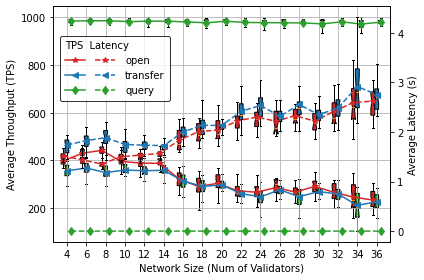

In [52]:
netsizes = np.arange(4,38,2)
# calculate_scaleout(consensus='QBFT', netsizes=netsizes)
fig = plot_scaleout(consensus='QBFT', netsizes=netsizes)
fig.set_size_inches(6, 4)
fig.savefig('./figs/scaleout-qbft.png', dpi=300)
fig.savefig('./figs/scaleout-qbft.pdf')

## Consensus Comparison

In [38]:
sendrate = 1000
dict_df = {}
netsizes = np.arange(4,38,2)
cons = ['QBFT', 'IBFT2', 'CLIQUE']
# reports_dir = '/home/ubuntu/mnt/experiments_bpet/reports/'

for consensus in cons:
    temp_df_ls = []
    for n in netsizes:
        folder = '{}_LB_2C7.5G_{}_1S'.format(n, consensus)
        if consensus in ['IBFT2', 'CLIQUE']:
            folder = '{}_LB_2C7.5G_{}_1S_1000TPS'.format(n, consensus)
        reports_path = basepath + folder
        print('Processing reports of {}'.format(folder))
        df, _ = get_df_multi_rounds(reports_path)
        df = df[df.Rate == sendrate]
        df = df.groupby(['Name']).mean()
        df['Netsize'] = n
        temp_df_ls.append(df)
    df = pd.concat(temp_df_ls)
    df.to_csv('{}{}_avg_scaleout.csv'.format(plotdatapath, consensus))
    dict_df[consensus] = df

Processing reports of 4_LB_2C7.5G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 6_LB_2C7.5G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 8_LB_2C7.5G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 10_LB_2C7.5G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 12_LB_2C7.5G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 14_LB_2C7.5G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 16_LB_2C7.5G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 18_LB_2C7.5G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 20_LB_2C7.5G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 22_LB_2C7.5G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 24_LB_2C7.5G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 26_LB_2C7.5G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 28_LB_2C7.5G_QBFT_1S
4 rounds of reports are 

In [50]:
df = pd.read_csv('{}QBFT_avg_scaleout.csv'.format(plotdatapath))

In [41]:
df = pd.read_csv('{}QBFT_avg_scaleout.csv'.format(plotdatapath))
qbft_open_tps = df[df['Name'] == 'open']['Throughput (TPS)'].values
qbft_open_lat = df[df['Name'] == 'open']['Avg Latency (s)'].values

qbft_transfer_tps = df[df['Name'] == 'transfer']['Throughput (TPS)'].values
qbft_transfer_lat = df[df['Name'] == 'transfer']['Avg Latency (s)'].values

qbft_query_tps = df[df['Name'] == 'query']['Throughput (TPS)'].values
qbft_query_lat = df[df['Name'] == 'query']['Avg Latency (s)'].values

df = pd.read_csv('{}IBFT2_avg_scaleout.csv'.format(plotdatapath))
ibft2_open_tps = df[df['Name'] == 'open']['Throughput (TPS)'].values
ibft2_open_lat = df[df['Name'] == 'open']['Avg Latency (s)'].values
ibft2_transfer_tps = df[df['Name'] == 'transfer']['Throughput (TPS)'].values
ibft2_transfer_lat = df[df['Name'] == 'transfer']['Avg Latency (s)'].values
ibft2_query_tps = df[df['Name'] == 'query']['Throughput (TPS)'].values
ibft2_query_lat = df[df['Name'] == 'query']['Avg Latency (s)'].values

df = pd.read_csv('{}CLIQUE_avg_scaleout.csv'.format(plotdatapath))
clique_open_tps = df[df['Name'] == 'open']['Throughput (TPS)'].values
clique_open_lat = df[df['Name'] == 'open']['Avg Latency (s)'].values
clique_transfer_tps = df[df['Name'] == 'transfer']['Throughput (TPS)'].values
clique_transfer_lat = df[df['Name'] == 'transfer']['Avg Latency (s)'].values
clique_query_tps = df[df['Name'] == 'query']['Throughput (TPS)'].values
clique_query_lat = df[df['Name'] == 'query']['Avg Latency (s)'].values

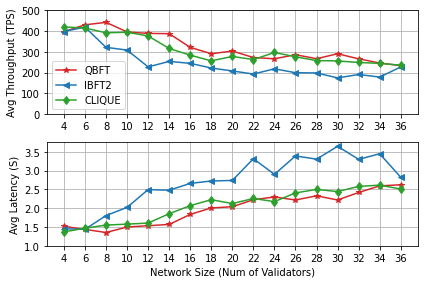

In [42]:
fig, axes = plt.subplots(figsize=(6,4), nrows=2, ncols=1)

xlabels = netsizes
axes[0].plot(netsizes, qbft_open_tps, marker='*', color='tab:red', label='QBFT')
axes[0].plot(netsizes, ibft2_open_tps, marker='<', color='tab:blue', label='IBFT2')
axes[0].plot(netsizes, clique_open_tps, marker='d', color='tab:green', label='CLIQUE')

axes[0].set_ylabel('Avg Throughput (TPS)')
axes[0].set_ylim(0,500)
axes[0].set_xticks(xlabels)
axes[0].set_xticklabels(xlabels)
axes[0].grid()
axes[0].legend()

axes[1].plot(netsizes, qbft_open_lat, marker='*', color='tab:red', label='QBFT')
axes[1].plot(netsizes, ibft2_open_lat, marker='<', color='tab:blue', label='IBFT2')
axes[1].plot(netsizes, clique_open_lat, marker='d', color='tab:green', label='CLIQUE')
axes[1].set_yticks(np.arange(1,4,0.5))
axes[1].set_xticks(xlabels)
axes[1].set_xticklabels(xlabels)
axes[1].set_xlabel('Network Size (Num of Validators)')
axes[1].set_ylabel('Avg Latency (S)')
axes[1].grid()
# axes[1].legend()
plt.tight_layout()
plt.show()
fig.set_size_inches(6,4)
fig.savefig('./figs/scaleout-consensus.png', dpi=300)
fig.savefig('./figs/scaleout-consensus.pdf')

# Scale-up 

In [47]:
def calculate_scaleup(consensus, flavors, file):
    sendrate = 1000
    open_lat, open_tps = [], []
    transfer_lat, transfer_tps = [], []
    query_lat, query_tps = [], []
    for fl in flavors:
        folder = '8_LB_{}_{}_1S'.format(fl, consensus)
        if consensus in ['IBFT2', 'CLIQUE']:
            folder = '8_LB_{}_{}_1S_1000TPS'.format(fl, consensus)
        reports_path = basepath+folder
        print('Processing {}'.format(folder))
        df, _ = get_df_multi_rounds(reports_path)
        df = df[df.Rate == sendrate]

        open_lat.append(df[df.Name=='open']['Avg Latency (s)'].values)
        open_tps.append(df[df.Name=='open']['Throughput (TPS)'].values)
        transfer_lat.append(df[df.Name=='transfer']['Avg Latency (s)'].values)
        transfer_tps.append(df[df.Name=='transfer']['Throughput (TPS)'].values)
        query_lat.append(df[df.Name=='query']['Avg Latency (s)'].values)
        query_tps.append(df[df.Name=='query']['Throughput (TPS)'].values)
    
    open_lat_mean, open_tps_mean = [np.mean(lat) for lat in open_lat], [np.mean(tps) for tps in open_tps]
    transfer_lat_mean, transfer_tps_mean = [np.mean(lat) for lat in transfer_lat], [np.mean(tps) for tps in transfer_tps]
    query_lat_mean, query_tps_mean = [np.mean(lat) for lat in query_lat], [np.mean(tps) for tps in query_tps]

    cols =['open_lat', 'open_tps', 'transfer_lat', 'transfer_tps', 'query_lat', 'query_tps']
    df = pd.DataFrame(list(zip(open_lat, open_tps, transfer_lat, transfer_tps, query_lat, query_tps)),columns=cols)
    df.to_csv(file)

def parse_values(values_str):
    res = []
    for line in values_str:
      line = [float(a) for a in line.replace('\n','').strip('][').split(' ') if (a != '')]
      res.append(line)
    return res

def plot_scaleup(consensus, flavors, file):
    sendrate = 1000
    df = pd.read_csv(file)
    open_lat, open_tps = parse_values(df['open_lat'].values), parse_values(df['open_tps'].values)
    transfer_lat, transfer_tps = parse_values(df['transfer_lat'].values), parse_values(df['transfer_tps'].values)
    query_lat, query_tps = parse_values(df['query_lat'].values), parse_values(df['query_tps'].values)

    open_lat_mean, open_tps_mean = [np.mean(lat) for lat in open_lat], [np.mean(tps) for tps in open_tps]
    transfer_lat_mean, transfer_tps_mean = [np.mean(lat) for lat in transfer_lat], [np.mean(tps) for tps in transfer_tps]
    query_lat_mean, query_tps_mean = [np.mean(lat) for lat in query_lat], [np.mean(tps) for tps in query_tps]
   
    # plot
    fig, ax1 = plt.subplots(figsize=(6, 4))
    showfliers = False
    showmeans = False
    patch_artist = True
    xlabels = flavors
    positions = np.arange(1, len(flavors)+1)
    width = 0.2
    widths = tuple([0.2] * len(flavors))

    ax1.boxplot(open_tps, positions=positions-width, sym='k+', notch=1, showfliers=showfliers, zorder=1, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:red"), widths=widths)
    ax1.plot(positions-width, open_tps_mean, color='tab:red', marker='*', label='open', zorder=2)
    ax1.boxplot(transfer_tps, positions=positions, sym='k+', notch=1, showfliers=showfliers, zorder=1, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"), widths=widths)
    ax1.plot(positions, transfer_tps_mean, color='tab:blue', marker='<', label='transfer', zorder=2)
    ax1.boxplot(query_tps, positions=positions+width, sym='k+', notch=1, showfliers=showfliers, zorder=1, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:green"), widths=widths)
    ax1.plot(positions+width, query_tps_mean, color='tab:green', marker='d', label='query', zorder=2)
    ax1.grid()

    # ax1.set_title("Besu Vertical Scalability")
    ax1.set_xlabel('Validator Node Flavors')
    ax1.set_ylabel('Average Throughput (TPS)')

    ax2 = ax1.twinx()
    ax2.boxplot(open_lat, positions=positions-width, sym='k+', notch=1, showfliers=showfliers, zorder=1, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:red"), widths=widths)
    ax2.plot(positions-width, open_lat_mean, '--', color='tab:red', marker='*', label='open', zorder=2)
    ax2.boxplot(transfer_lat, positions=positions, sym='k+', notch=1, showfliers=showfliers, zorder=1, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"), widths=widths)
    ax2.plot(positions, transfer_lat_mean, '--', color='tab:blue', marker='<', label='transfer', zorder=2)
    ax2.boxplot(query_lat, positions=positions+width, sym='k+', notch=1, widths=widths, zorder=1, showfliers=showfliers, patch_artist=patch_artist, boxprops=dict(facecolor="tab:green"), showmeans=showmeans)
    ax2.plot(positions+width, query_lat_mean, '--', color='tab:green', marker='d', label='query', zorder=2)
    ax2.set_ylabel('Average Latency (s)')

    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    ax2.set_xticks(positions)
    ax2.set_xticklabels(flavors)
    leg = ax2.legend((*handles1, *handles2), (*len(labels1)*[''], *labels2), title='TPS  Latency',
                loc=(0.65,0.63), ncol=2, handlelength=2, edgecolor='black',
                borderpad=0.5, handletextpad=1, columnspacing=0)
    leg._legend_box.align = "left"
    plt.tight_layout()
    plt.show()
    return fig

## QBFT

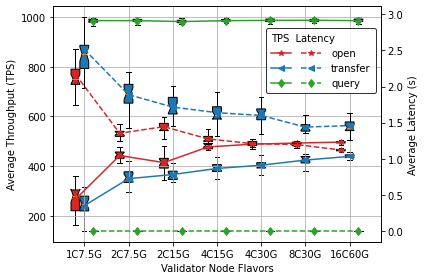

In [49]:
cons = ['QBFT', 'IBFT2', 'CLIQUE']
file = '{}qbft_scaleup.csv'.format(plotdatapath)
flavors = ['1C7.5G', '2C7.5G', '2C15G', '4C15G', '4C30G', '8C30G', '16C60G']
# calculate_scaleup(cons[0], flavors, file)
fig = plot_scaleup(cons[0], flavors, file)
fig.set_size_inches(6, 4)
fig.savefig('./figs/scaleup-qbft.png', dpi=300)
fig.savefig('./figs/scaleup-qbft.pdf')

## Consensus Comparison

In [51]:
sendrate = 1000
# dict_df = {}
flavors = ['1C7.5G', '2C7.5G', '2C15G', '4C15G', '4C30G', '8C30G', '16C60G']
cons = ['QBFT', 'IBFT2', 'CLIQUE']
# reports_dir = '/home/ubuntu/mnt/experiments_bpet/reports/'

for consensus in cons:
    temp_df_ls = []
    for f in flavors:
        folder = '8_LB_{}_{}_1S'.format(f, consensus)
        if consensus in ['IBFT2', 'CLIQUE']:
            folder = '8_LB_{}_{}_1S_1000TPS'.format(f, consensus)
        reports_path = basepath + folder
        print('Processing reports of {}'.format(folder))
        df, _ = get_df_multi_rounds(reports_path)
        df = df[df.Rate == sendrate]
        df = df.groupby(['Name']).mean()
        df['Flavor'] = f
        temp_df_ls.append(df)
    df = pd.concat(temp_df_ls)
    df.to_csv('{}{}_avg_scaleup.csv'.format(plotdatapath, consensus))
    # dict_df[consensus] = df

Processing reports of 8_LB_1C7.5G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 8_LB_2C7.5G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 8_LB_2C15G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 8_LB_4C15G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 8_LB_4C30G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 8_LB_8C30G_QBFT_1S
20220415-043110 has 47 reports.
5 rounds of reports are collected!
Processing reports of 8_LB_16C60G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 8_LB_1C7.5G_IBFT2_1S_1000TPS
20220511-112054 has 25 reports.
1 rounds of reports are collected!
Processing reports of 8_LB_2C7.5G_IBFT2_1S_1000TPS
20220513-010336 has 25 reports.
1 rounds of reports are collected!
Processing reports of 8_LB_2C15G_IBFT2_1S_1000TPS
20220511-115535 has 25 reports.
1 rounds of reports are collected!
Processing reports of 8_LB_4C15G_IBFT2_1S_1000TPS
20220511-122446 has 25 reports

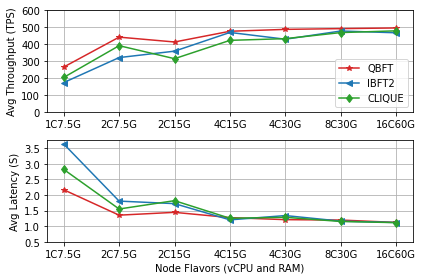

In [5]:
# LOAD DATA
sendrate = 1000
flavors = ['1C7.5G', '2C7.5G', '2C15G', '4C15G', '4C30G', '8C30G', '16C60G']
cons = ['QBFT', 'IBFT2', 'CLIQUE']

df = pd.read_csv('{}{}_avg_scaleup.csv'.format(plotdatapath, 'QBFT'))
qbft_open_tps = df[df['Name'] == 'open']['Throughput (TPS)'].values
qbft_open_lat = df[df['Name'] == 'open']['Avg Latency (s)'].values

qbft_transfer_tps = df[df['Name'] == 'transfer']['Throughput (TPS)'].values
qbft_transfer_lat = df[df['Name'] == 'transfer']['Avg Latency (s)'].values

qbft_query_tps = df[df['Name'] == 'query']['Throughput (TPS)'].values
qbft_query_lat = df[df['Name'] == 'query']['Avg Latency (s)'].values

df = pd.read_csv('{}{}_avg_scaleup.csv'.format(plotdatapath, 'IBFT2'))
ibft2_open_tps = df[df['Name'] == 'open']['Throughput (TPS)'].values
ibft2_open_lat = df[df['Name'] == 'open']['Avg Latency (s)'].values
ibft2_transfer_tps = df[df['Name'] == 'transfer']['Throughput (TPS)'].values
ibft2_transfer_lat = df[df['Name'] == 'transfer']['Avg Latency (s)'].values
ibft2_query_tps = df[df['Name'] == 'query']['Throughput (TPS)'].values
ibft2_query_lat = df[df['Name'] == 'query']['Avg Latency (s)'].values

df = pd.read_csv('{}{}_avg_scaleup.csv'.format(plotdatapath, 'CLIQUE'))
clique_open_tps = df[df['Name'] == 'open']['Throughput (TPS)'].values
clique_open_lat = df[df['Name'] == 'open']['Avg Latency (s)'].values
clique_transfer_tps = df[df['Name'] == 'transfer']['Throughput (TPS)'].values
clique_transfer_lat = df[df['Name'] == 'transfer']['Avg Latency (s)'].values
clique_query_tps = df[df['Name'] == 'query']['Throughput (TPS)'].values
clique_query_lat = df[df['Name'] == 'query']['Avg Latency (s)'].values

# PLOT
fig, axes = plt.subplots(figsize=(6,4), nrows=2, ncols=1)

xlabels = flavors
X_axis = np.arange(1, len(flavors)+1)
axes[0].plot(X_axis, qbft_open_tps, marker='*', color='tab:red', label='QBFT')
axes[0].plot(X_axis, ibft2_open_tps, marker='<', color='tab:blue', label='IBFT2')
axes[0].plot(X_axis, clique_open_tps, marker='d', color='tab:green', label='CLIQUE')

axes[0].set_ylabel('Avg Throughput (TPS)')
axes[0].set_yticks(np.arange(0,650,100))
axes[0].set_xticks(X_axis)
axes[0].set_xticklabels(xlabels)
axes[0].grid()
axes[0].legend()

axes[1].plot(X_axis, qbft_open_lat, marker='*', color='tab:red', label='QBFT')
axes[1].plot(X_axis, ibft2_open_lat, marker='<', color='tab:blue', label='IBFT2')
axes[1].plot(X_axis, clique_open_lat, marker='d', color='tab:green', label='CLIQUE')
axes[1].set_yticks(np.arange(0.5,4,0.5))
axes[1].set_xticks(X_axis)
axes[1].set_xticklabels(xlabels)
axes[1].set_xlabel('Node Flavors (vCPU and RAM)')
axes[1].set_ylabel('Avg Latency (S)')
axes[1].grid()
# axes[1].legend()
plt.tight_layout()
plt.show()

fig.set_size_inches(6,4)
fig.savefig('./figs/scaleup-consensus.png', dpi=300)
fig.savefig('./figs/scaleup-consensus.pdf')

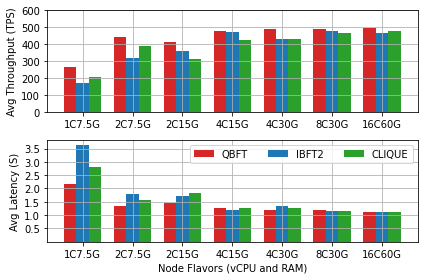

In [15]:
# PLOT
fig, axes = plt.subplots(figsize=(6,4), nrows=2, ncols=1)
width = 0.25

xlabels = flavors
X_axis = np.arange(1, len(flavors)+1)
# axes[0].plot(X_axis, qbft_open_tps, marker='*', color='tab:red', label='QBFT')
# axes[0].plot(X_axis, ibft2_open_tps, marker='<', color='tab:blue', label='IBFT2')
# axes[0].plot(X_axis, clique_open_tps, marker='d', color='tab:green', label='CLIQUE')

axes[0].bar(X_axis-width, qbft_open_tps, width, color='tab:red', label='QBFT')
axes[0].bar(X_axis, ibft2_open_tps, width, color='tab:blue', label='IBFT2')
axes[0].bar(X_axis+width, clique_open_tps, width, color='tab:green', label='CLIQUE')

axes[0].set_ylabel('Avg Throughput (TPS)')
axes[0].set_yticks(np.arange(0,650,100))
axes[0].set_xticks(X_axis)
axes[0].set_xticklabels(xlabels)
axes[0].grid()
# axes[0].legend()

axes[1].bar(X_axis-width, qbft_open_lat, width, color='tab:red', label='QBFT')
axes[1].bar(X_axis, ibft2_open_lat, width, color='tab:blue', label='IBFT2')
axes[1].bar(X_axis+width, clique_open_lat, width, color='tab:green', label='CLIQUE')
axes[1].set_yticks(np.arange(0.5,4,0.5))
axes[1].set_xticks(X_axis)
axes[1].set_xticklabels(xlabels)
axes[1].set_xlabel('Node Flavors (vCPU and RAM)')
axes[1].set_ylabel('Avg Latency (S)')
axes[1].grid()
axes[1].legend(loc='upper right', ncol=3)
plt.tight_layout()
plt.show()

fig.set_size_inches(6,4)
fig.savefig('./figs/scaleup-consensus-bar.png', dpi=300)
fig.savefig('./figs/scaleup-consensus-bar.pdf')

# Baseline

In [53]:
reports_path = '{}8_LB_2C7.5G_QBFT_1S'.format(basepath)
df_perf, df_res = get_df_multi_rounds(reports_path)
df = cal_mean(df_perf)
df_perf.to_csv('{}baseline_perf.csv'.format(plotdatapath))

5 rounds of reports are collected!


In [53]:
def plot_baseline_perf(df_perf, y2lim=None):
    
    open_lat, open_tps = [], []
    transfer_lat, transfer_tps = [], []
    query_lat, query_tps = [], []
    rates = sorted(df_perf.Rate.unique().astype(int))
    for rate in rates:
        df = df_perf[(df_perf.Name=='open') & (df_perf.Rate==rate)]
        open_lat.append(df['Avg Latency (s)'].values)
        open_tps.append(df['Throughput (TPS)'].values)
        df = df_perf[(df_perf.Name=='transfer') & (df_perf.Rate==rate)]
        transfer_lat.append(df['Avg Latency (s)'].values)
        transfer_tps.append(df['Throughput (TPS)'].values)
        df = df_perf[(df_perf.Name=='query') & (df_perf.Rate==rate)]
        query_lat.append(df['Avg Latency (s)'].values)
        query_tps.append(df['Throughput (TPS)'].values)

    open_tps_mean = [np.mean(tps) for tps in open_tps]
    open_lat_mean = [np.mean(lat) for lat in open_lat]

    transfer_tps_mean = [np.mean(tps) for tps in transfer_tps]
    transfer_lat_mean = [np.mean(lat) for lat in transfer_lat]

    query_tps_mean = [np.mean(tps) for tps in query_tps]
    query_lat_mean = [np.mean(lat) for lat in query_lat]

    fig, ax1 = plt.subplots(figsize=(6, 4))
    X_axis = np.arange(1, len(rates)+1)
    showfliers=False
    showmeans=False
    patch_artist=True

    positions = np.arange(1, len(rates)+1)
    width = 0.2
    widths = tuple([0.2] * len(rates))

    ax1.boxplot(open_tps, positions=positions-width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:red"),widths=widths)
    ax1.plot(positions-width, open_tps_mean, color='tab:red', marker='<', label='open')
    ax1.boxplot(transfer_tps, positions=positions, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"),widths=widths)
    ax1.plot(positions, transfer_tps_mean, color='tab:blue', marker='d', label='transfer')
    ax1.boxplot(query_tps, positions=positions+width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:green"),widths=widths)
    ax1.plot(positions+width, query_tps_mean, color='tab:green', marker='*', label='query')

    ax1.grid()

    ax1.set_ylim(0, 1000)
    ax1.set_xlabel('Transaction send rate (req/s)')
    ax1.set_ylabel('Average Throughput (TPS)')

    ax2 = ax1.twinx()
    ax2.boxplot(open_lat, positions=positions-width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:red"),widths=widths)
    ax2.plot(positions-width, open_lat_mean, '--', color='tab:red', marker='<', label='open')
    ax2.boxplot(transfer_lat, positions=positions, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"),widths=widths)
    ax2.plot(positions, transfer_lat_mean, '--', color='tab:blue', marker='d', label='transfer')
    ax2.boxplot(query_lat, positions=positions+width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:green"),widths=widths)
    ax2.plot(positions+width, query_lat_mean, '--', color='tab:green', marker='*', label='query')
    ax2.set_xticks(X_axis)
    ax2.set_xticklabels(rates)
    if y2lim:
        ax2.set_ylim(0, y2lim)

    ax2.set_ylabel('Average Latency (s)')
    # ax2.set_xlabel('Send rate')

    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    leg = ax1.legend((*handles1, *handles2), (*len(labels1)*[''], *labels2), title='TPS  Latency',
                loc='upper left', ncol=2, handlelength=2, edgecolor='black',
                borderpad=0.5, handletextpad=1, columnspacing=0)
    leg._legend_box.align = "left"

    plt.tight_layout()
    plt.show()
    return fig

In [55]:
df_perf = pd.read_csv('{}baseline_perf.csv'.format(plotdatapath))
df_perf

,Unnamed: 0,Name,Succ,Fail,Send Rate (TPS),Max Latency (s),Min Latency (s),Avg Latency (s),Throughput (TPS),Rate
0,0,open,1000,0,100.4,1.44,0.21,0.78,95.2,100
1,1,query,1000,0,100.3,0.06,0.00,0.00,100.3,100
2,2,transfer,1000,0,100.4,1.26,0.13,0.70,95.3,100
3,0,open,1000,0,100.4,1.24,0.13,0.68,94.3,100
4,1,query,1000,0,100.4,0.05,0.00,0.00,100.3,100
...,...,...,...,...,...,...,...,...,...,...
745,1,query,1000,0,892.1,0.04,0.00,0.00,891.3,900
746,2,transfer,1000,0,892.9,1.90,1.15,1.53,394.3,900
747,0,open,1000,0,903.3,1.85,1.03,1.39,414.1,900
748,1,query,1000,0,889.7,0.01,0.00,0.00,888.9,900


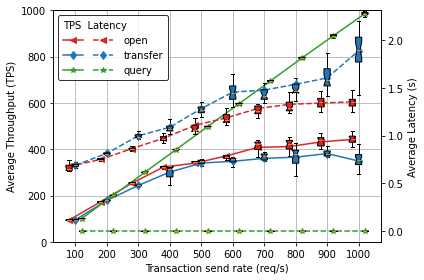

In [54]:

df_perf = pd.read_csv('{}baseline_perf.csv'.format(plotdatapath))
fig = plot_baseline_perf(df_perf)
fig.set_size_inches(6,4)
fig.savefig('./figs/baseline-bp.png', dpi=300)
fig.savefig('./figs/baseline-bp.pdf')

# Consensus

In [16]:
consensus = ['QBFT', 'IBFT2', 'CLIQUE']
metrics = ['Throughput (TPS)', 'Avg Latency (s)']
tx_types = ['open', 'transfer', 'query']
send_rates = np.arange(100, 110, 100)

df_perf_ls = []
df_res_ls = []
   
for c in consensus:
    reports_path = '/home/ubuntu/mnt/experiments_bpet/reports/8_LB_2C7.5G_{}_1S'.format(c)
    df_perf, df_res = get_df_multi_rounds(reports_path)

    df_perf_ls.append(df_perf)

    df_res.set_index('Name', inplace=True)
    df_res.index = [index.split('/')[1] for index in df_res.index]
    
    df_res_ls.append(df_res)

open_tps, open_lat = [], []
transfer_tps, transfer_lat = [], []
query_tps, query_lat = [], []

for i in range(len(consensus)):
    df_curr = df_perf_ls[i]
    
    df = df_curr[df_curr.Name=='open'].sort_values(by='Rate')
    df = df.groupby(by='Rate').mean()
    open_lat.append(list(df['Avg Latency (s)'].values))
    open_tps.append(list(df['Throughput (TPS)'].values))
    
    df = df_curr[df_curr.Name=='transfer'].sort_values(by='Rate')
    df = df.groupby(by='Rate').mean()
    transfer_lat.append(list(df['Avg Latency (s)'].values))
    transfer_tps.append(list(df['Throughput (TPS)'].values))
    
    df = df_curr[df_curr.Name=='query'].sort_values(by='Rate')
    df = df.groupby(by='Rate').mean()
    query_lat.append(list(df['Avg Latency (s)'].values))
    query_tps.append(list(df['Throughput (TPS)'].values))

5 rounds of reports are collected!
5 rounds of reports are collected!
5 rounds of reports are collected!


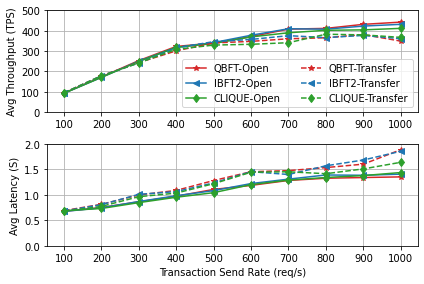

In [17]:
rates = np.arange(100, 1100, 100)
width = 0.2
X_axis = np.arange(1, len(rates)+1)

fig, axes = plt.subplots(figsize=(6,4), nrows=2, ncols=1, sharex=False)
axes[0].plot(X_axis, open_tps[0], marker='*',label='QBFT-Open', color='tab:red')
axes[0].plot(X_axis, open_tps[1], marker='<',label='IBFT2-Open', color='tab:blue')
axes[0].plot(X_axis, open_tps[2], marker='d',label='CLIQUE-Open', color='tab:green')

axes[0].plot(X_axis, transfer_tps[0], '--', marker='*', label='QBFT-Transfer', color='tab:red')
axes[0].plot(X_axis, transfer_tps[1], '--', marker='<', label='IBFT2-Transfer', color='tab:blue')
axes[0].plot(X_axis, transfer_tps[2], '--', marker='d', label='CLIQUE-Transfer', color='tab:green', )

axes[0].set(ylabel='Avg Throughput (TPS)')
axes[0].set_ylim(0, 500)
axes[0].grid()
axes[0].set_xticks(X_axis)
axes[0].set_xticklabels(rates)
axes[0].legend(ncol=2)

axes[1].plot(X_axis, open_lat[0], label='QBFT', marker='*', color='tab:red')
axes[1].plot(X_axis, open_lat[1], label='IBFT2', marker='<', color='tab:blue')
axes[1].plot(X_axis, open_lat[2], label='CLIQUE', marker='d', color='tab:green')

axes[1].plot(X_axis, transfer_lat[0], label='QBFT', linestyle='--', marker='*', color='tab:red')
axes[1].plot(X_axis, transfer_lat[1], label='IBFT2', linestyle='--', marker='<', color='tab:blue')
axes[1].plot(X_axis, transfer_lat[2], label='CLIQUE', linestyle='--', marker='d', color='tab:green')
axes[1].set_ylim(0, 2.)
axes[1].set_ylabel('Avg Latency (S)')
axes[1].set_xlabel('Transaction Send Rate (req/s)')
axes[1].grid()

axes[1].set_xticks(X_axis)
axes[1].set_xticklabels(rates)
plt.tight_layout()
plt.show()

fig.set_size_inches(6, 4)
# fig.savefig('./figs/consensus.png', dpi=300)
fig.savefig('./figs/consensus.pdf')

# Balance vs non-balance

In [57]:
reports_path = '{}8_NLB_2C7.5G_QBFT_1S'.format(basepath)
df_perf, df_res = get_df_multi_rounds(reports_path)
df_perf.to_csv('{}baseline_nlb.csv'.format(plotdatapath))

5 rounds of reports are collected!


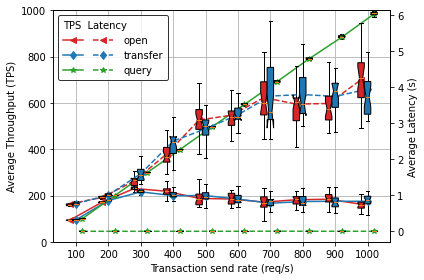

In [55]:
plotdata = '{}baseline_nlb.csv'.format(plotdatapath)
df_perf = pd.read_csv(plotdata)
fig = plot_baseline_perf(df_perf)
fig.set_size_inches(6,4)
fig.savefig('./figs/nlb.png', dpi=300)
fig.savefig('./figs/nlb.pdf')

# Block Time

In [2]:
# CALCULATE PLOT DATA
blocktimes = np.arange(1, 6)

roundLabels = ['open', 'query', 'transfer']
metricLabels = ['Throughput (TPS)', 'Avg Latency (s)']
file = '{}blocktime.csv'.format(plotdatapath)

open_lat, open_tps = [], []
transfer_lat, transfer_tps = [], []
query_lat, query_tps = [], []

sendrate = 1000
for blt in blocktimes:
    reports_path = '{}8_LB_2C7.5G_QBFT_{}S'.format(basepath, blt)
    df, _ = get_df_multi_rounds(reports_path)
    df = df[df.Rate == sendrate]

    open_lat.append(df[df.Name=='open']['Avg Latency (s)'].values)
    open_tps.append(df[df.Name=='open']['Throughput (TPS)'].values)
    transfer_lat.append(df[df.Name=='transfer']['Avg Latency (s)'].values)
    transfer_tps.append(df[df.Name=='transfer']['Throughput (TPS)'].values)
    query_lat.append(df[df.Name=='query']['Avg Latency (s)'].values)
    query_tps.append(df[df.Name=='query']['Throughput (TPS)'].values)

cols =['open_lat', 'open_tps', 'transfer_lat', 'transfer_tps', 'query_lat', 'query_tps']
df = pd.DataFrame(list(zip(open_lat, open_tps, transfer_lat, transfer_tps, query_lat, query_tps)),columns=cols)
df.to_csv(file)

5 rounds of reports are collected!
13 rounds of reports are collected!
6 rounds of reports are collected!
20220509-121932 has 34 reports.
11 rounds of reports are collected!
5 rounds of reports are collected!


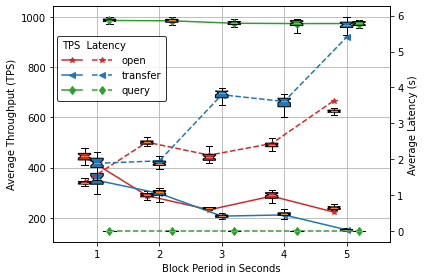

In [4]:
# LOAD DATA
blocktimes = np.arange(1, 6)
file = '{}blocktime.csv'.format(plotdatapath)
df = pd.read_csv(file)

open_lat, open_tps = parse_values(df['open_lat'].values), parse_values(df['open_tps'].values)
transfer_lat, transfer_tps = parse_values(df['transfer_lat'].values), parse_values(df['transfer_tps'].values)
query_lat, query_tps = parse_values(df['query_lat'].values), parse_values(df['query_tps'].values)

open_lat_mean, open_tps_mean = [np.mean(lat) for lat in open_lat], [np.mean(tps) for tps in open_tps]
transfer_lat_mean, transfer_tps_mean = [np.mean(lat) for lat in transfer_lat], [np.mean(tps) for tps in transfer_tps]
query_lat_mean, query_tps_mean = [np.mean(lat) for lat in query_lat], [np.mean(tps) for tps in query_tps]

# PLOT
fig, ax1 = plt.subplots(figsize=(6, 4))
showfliers = False
showmeans = False
patch_artist = True
xlabels = blocktimes
positions = np.arange(1, len(blocktimes)+1)
width = 0.2
widths = tuple([0.2] * len(blocktimes))

ax1.boxplot(open_tps, positions=positions-width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:red"), widths=widths)
ax1.plot(positions-width, open_tps_mean, color='tab:red', marker='*', label='open')
ax1.boxplot(transfer_tps, positions=positions, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"), widths=widths)
ax1.plot(positions, transfer_tps_mean, color='tab:blue', marker='<', label='transfer')
ax1.boxplot(query_tps, positions=positions+width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:green"), widths=widths)
ax1.plot(positions+width, query_tps_mean, color='tab:green', marker='d', label='query')
# ax1.set_ylim(100, 1000)
ax1.grid()

# ax1.set_title("Besu Performance under Varying Block Period Time")
ax1.set_xlabel('Block Period in Seconds')
ax1.set_ylabel('Average Throughput (TPS)')

ax2 = ax1.twinx()
ax2.boxplot(open_lat, positions=positions-width, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:red"), widths=widths)
ax2.plot(positions-width, open_lat_mean, '--', color='tab:red', marker='*', label='open')
ax2.boxplot(transfer_lat, positions=positions, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"), widths=widths)
ax2.plot(positions, transfer_lat_mean, '--', color='tab:blue', marker='<', label='transfer')
ax2.boxplot(query_lat, positions=positions+width, sym='k+', notch=1, widths=widths, showfliers=showfliers, patch_artist=patch_artist, boxprops=dict(facecolor="tab:green"), showmeans=showmeans)
ax2.plot(positions+width, query_lat_mean, '--', color='tab:green', marker='d', label='query')
ax2.set_ylabel('Average Latency (s)')
# ax2.set(xticklabels=[])

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

ax2.set_xticks(positions)
ax2.set_xticklabels(blocktimes)

leg = ax2.legend((*handles1, *handles2), (*len(labels1)*[''], *labels2), title='TPS  Latency',
             loc=(0.01,0.6), ncol=2, handlelength=2, edgecolor='black', 
             borderpad=0.5, handletextpad=1, columnspacing=0)
leg._legend_box.align = "left"

plt.tight_layout()
plt.show()

fig.set_size_inches(6, 4)
fig.savefig('./figs/blocktime.png', dpi=300)
fig.savefig('./figs/blocktime.pdf')

# Consensus time ratio in latency as net size increases

In [5]:
# get average latency of open and transfer for N=4->36
def get_mean_latency(consensus, netsizes):
    sendrate = 1000
    open_lat, transfer_lat = [], []
    reports_dir = '/home/ubuntu/mnt/experiments_bpet/reports/'
    for n in netsizes:
        folder = '{}_LB_2C7.5G_{}_1S'.format(n, consensus)
        if consensus in ['IBFT2', 'CLIQUE']:
            folder = '{}_LB_2C7.5G_{}_1S_1000TPS'.format(n, consensus)
        reports_path = reports_dir + folder
        print('Processing reports of {}'.format(folder))
        df, _ = get_df_multi_rounds(reports_path)
        df = df[df.Rate == sendrate]

        open_lat.append(df[df.Name=='open']['Avg Latency (s)'].values)
        
        transfer_lat.append(df[df.Name=='transfer']['Avg Latency (s)'].values)

    open_lat_mean = [np.mean(lat) for lat in open_lat]
    transfer_lat_mean = [np.mean(lat) for lat in transfer_lat]

    mean_lat = []
    l = len(netsizes)
    for i in range(l):
      mean_lat.append(np.mean([open_lat_mean[i], transfer_lat_mean[i]]))
    return mean_lat

netsizes = np.arange(4,38,2)
mean_latency = get_mean_latency(consensus='QBFT', netsizes=netsizes)

Processing reports of 4_LB_2C7.5G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 6_LB_2C7.5G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 8_LB_2C7.5G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 10_LB_2C7.5G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 12_LB_2C7.5G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 14_LB_2C7.5G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 16_LB_2C7.5G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 18_LB_2C7.5G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 20_LB_2C7.5G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 22_LB_2C7.5G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 24_LB_2C7.5G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 26_LB_2C7.5G_QBFT_1S
5 rounds of reports are collected!
Processing reports of 28_LB_2C7.5G_QBFT_1S
4 rounds of reports are 

In [6]:
# get average consensus time for N=4->36
import json
with open('./data/ct_all.json', 'r') as f:
    ct_data = json.load(f)['data']

ct_mean = []
for d in ct_data:
    ct_mean.append(np.mean(d))


In [20]:
print(np.round(mean_latency, 2))
print(np.round(ct_mean, 2))
print(np.round(np.array(mean_latency) - np.array(ct_mean), 2))

[1.63 1.63 1.62 1.62 1.64 1.65 1.92 2.07 2.09 2.32 2.42 2.27 2.44 2.28
 2.45 2.76 2.69]
[0.25 0.31 0.31 0.37 0.43 0.45 0.51 0.59 0.62 0.77 0.82 0.76 0.91 0.8
 0.91 1.12 1.11]
[1.37 1.32 1.31 1.26 1.2  1.2  1.41 1.48 1.47 1.55 1.6  1.51 1.53 1.48
 1.54 1.64 1.58]


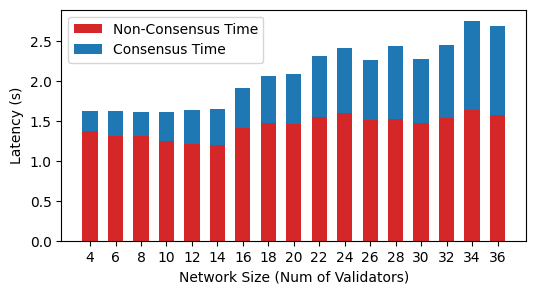

In [3]:
import matplotlib.pyplot as plt
import numpy as np

ct_mean = [0.25, 0.31, 0.31, 0.37, 0.43, 0.45, 0.51, 0.59, 0.62, 0.77, 0.82, 0.76, 0.91, 0.8, 0.91, 1.12, 1.11]
mean_latency = [1.63, 1.63, 1.62, 1.62, 1.64, 1.65, 1.92, 2.07, 2.09, 2.32, 2.42, 2.27, 2.44, 2.28, 2.45, 2.76, 2.69]
non_ct = np.round(np.array(mean_latency) - np.array(ct_mean), 2)
netsizes = np.arange(4,38,2) 
# plot the ratio of consensus time in latency
fig, ax = plt.subplots(figsize=(6,3))
x_loc = np.arange(1, len(netsizes)+1)
width = 0.6
ax.bar(x_loc, non_ct, width, color='tab:red', zorder=1)
ax.bar(x_loc, ct_mean, width, bottom=non_ct, color='tab:blue')
ax.set_xlabel('Network Size (Num of Validators)')
ax.set_ylabel('Latency (s)')
ax.set_xticks(x_loc)
ax.set_xticklabels(netsizes)
ax.legend(labels=['Non-Consensus Time', 'Consensus Time'])
plt.show()

In [6]:
fig.set_size_inches(6, 3)
fig.savefig('ct_vs_nonct.pdf', bbox_inches = 'tight')